In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy

from joblib import load, dump

import model_functions as mf
import eval_measures as ems

from IPython.display import display

MF reloaded 1
EMS reloaded


In [2]:
sns.set_context("paper")
sns.set_style("ticks")

In [3]:
%%time
with pd.HDFStore('out/Training_2002_2005.h5') as cstore:
    df_first = cstore['first_author']
    df_last = cstore['last_author']
    
print df_first.shape, df_last.shape
df_first.columns

(41618369, 56) (41618369, 56)
CPU times: user 1min 18s, sys: 45.7 s, total: 2min 3s
Wall time: 2min 3s


In [4]:
df_first.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

## Load author years data

In [5]:
%%time
df_authors = pd.read_csv("data/AuthorityFirstLastYears.txt", sep="\t").rename(
    columns={"au_id": "auid"})
df_authors.shape

CPU times: user 9.46 s, sys: 1.6 s, total: 11.1 s
Wall time: 11.1 s


In [6]:
df_authors.head()

,auid,first_year,last_year
0,9731334_2,1997,2009
1,2155715_1,1990,2009
2,7867892_1,1994,2009
3,14609221_2,2003,2009
4,8101337_1,1993,2007


In [7]:
df_authors.dtypes

auid          object
first_year     int64
last_year      int64
dtype: object

In [8]:
df_authors.describe().astype(int)

,first_year,last_year
count,9300182,9300182
mean,1989,1994
std,16,15
min,1865,0
25%,1980,1986
50%,1994,2000
75%,2003,2007
max,9999,2099


In [9]:
df_authors[df_authors.first_year == 9999].shape, df_authors[df_authors.first_year <= 1900].shape

((3, 3), (3858, 3))

## Load author expertise data

In [10]:
%%time
df_expertise = pd.read_csv("data/AuthorExpertise.txt", sep="\t")
df_expertise.columns, df_expertise.shape

CPU times: user 1min 3s, sys: 7.96 s, total: 1min 11s
Wall time: 1min 11s


In [11]:
df_expertise.columns, df_expertise.shape

(Index([u'PMID', u'auid', u'match_len', u'match_prop', u'overall_coverage_len',
        u'overall_coverage_prop'],
       dtype='object'), (58761322, 6))

In [12]:
df_expertise.dtypes

PMID                       int64
auid                      object
match_len                  int64
match_prop               float64
overall_coverage_len       int64
overall_coverage_prop    float64
dtype: object

## First author

In [13]:
%%time
print df_first.shape
df_first = df_first.merge(df_authors, how="left", on="auid")
print df_first.shape

(41618369, 56)
(41618369, 58)
CPU times: user 1min 17s, sys: 42.8 s, total: 1min 59s
Wall time: 1min 59s


In [14]:
df_first["au_age"] = df_first["source_year"] - df_first["first_year"]

In [15]:
df_first.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [16]:
%%time
print df_first.shape
df_first = df_first.merge(df_expertise, how="left",
                          left_on=["source_id","auid"],
                          right_on=["PMID","auid"],)
print df_first.shape

(41618369, 59)
(41619240, 64)
CPU times: user 1min 9s, sys: 20.4 s, total: 1min 30s
Wall time: 1min 30s


In [17]:
df_first.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [18]:
%%time
df_first = df_first.drop("PMID", axis=1)
print df_first.shape

(41619240, 63)
CPU times: user 36.4 s, sys: 37.5 s, total: 1min 13s
Wall time: 1min 13s


## Last author

In [19]:
%%time
print df_last.shape
df_last = df_last.merge(df_authors, how="left", on="auid")
print df_last.shape

(41618369, 56)
(41618369, 58)
CPU times: user 1min 27s, sys: 39.6 s, total: 2min 7s
Wall time: 2min 7s


In [20]:
df_last["au_age"] = df_last["source_year"] - df_last["first_year"]

In [21]:
%%time
print df_last.shape
df_last = df_last.merge(df_expertise, how="left",
                          left_on=["source_id","auid"],
                          right_on=["PMID","auid"],)
print df_last.shape
df_last = df_last.drop("PMID", axis=1)
print df_last.shape

(41618369, 59)
(41619267, 64)
(41619267, 63)
CPU times: user 1min 54s, sys: 1min 7s, total: 3min 1s
Wall time: 3min 1s


## Modelling considerations

In [22]:
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
GENDERS = ["-", "F", "M"]

def prepare_data(df):
    df["eth_weight"] = 0.5 # Partial weight to multi ethnicity
    df.ix[df.eth2 == "UNKNOWN", "eth_weight"] = 1 # Full weight to single ethnicity
    df.ix[df.source_country == "-", "source_country"] = "UNKNOWN" # Set - to unknown
    df.source_country = df.source_country.astype("category", categories=TOP_15_COUNTRIES, ordered=False).fillna("OTHER")
    df.ix[df.eth1.isin(
        ["UNKNOWN", "TOOSHORT", "ERROR"]),
      "eth1"] = "UNKNOWN" # Set unknown ethnicities
    df.ix[df.eth2.isin(
            ["UNKNOWN", "TOOSHORT", "ERROR"]),
          "eth2"] = "UNKNOWN" # Set unknown ethnicities
    df.eth1 = df.eth1.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")
    df.eth2 = df.eth2.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")
    df.gender = df.gender.astype("category", categories=GENDERS, ordered=False).fillna("-")
    df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']] = df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']].astype("bool")

In [23]:
prepare_data(df_first)
prepare_data(df_last)

## Tables of gender self citation for age and prior papers

In [24]:
def filtered_data(df):
    # Base version 1
    df_filtered = df[(df.gender != "-")
                & (df.source_ncites >= 10)
                & (df.source_ncites <=60)]
    print df_filtered.shape, df.shape
    print "Filter dataset is %.2f%% of the original data." % (df_filtered.shape[0] * 100./df.shape[0])
    return df_filtered

def aggregate_function(x, median_col="auth_prev_papers", span=1):
    median = x[median_col].median()
    x = x[(x[median_col] >= (median - span))
         & (x[median_col] <= (median + span))]
    t = x.groupby("gender")["is_self_cite"].agg([np.mean, len])
    t["median"] = median
    return t

### First author

In [25]:
%%time
df_t_first = filtered_data(df_first)
display(df_t_first.pivot_table(index=pd.cut(df_t_first.au_age,
                                    bins=[4,6,8,12,18,22,27,33]),
                      columns="gender", values="is_self_cite", aggfunc=[np.mean, len]))

(26148675, 64) (41619240, 64)
Filter dataset is 62.83% of the original data.


mean                     len                      
gender      -         F         M   -          F          M
au_age                                                     
(4, 6]    NaN  0.039301  0.045931 NaN  1075897.0  1850463.0
(6, 8]    NaN  0.044391  0.053354 NaN   797698.0  1502238.0
(8, 12]   NaN  0.053800  0.063481 NaN  1037551.0  2141894.0
(12, 18]  NaN  0.068604  0.080691 NaN   881774.0  2023373.0
(18, 22]  NaN  0.080206  0.096689 NaN   361556.0   927872.0
(22, 27]  NaN  0.088466  0.109285 NaN   292644.0   863976.0
(27, 33]  NaN  0.096430  0.125897 NaN   189672.0   682763.0

CPU times: user 14.5 s, sys: 10.9 s, total: 25.4 s
Wall time: 25.4 s


In [26]:
df_t_first[["gender", "is_self_cite"]].groupby("gender").is_self_cite.mean()* 100

gender
-         NaN
F    3.962280
M    5.787288
Name: is_self_cite, dtype: float64

### Last author

In [27]:
%%time
df_t_last = filtered_data(df_last)
display(df_t_last.pivot_table(index=pd.cut(df_t_last.au_age,
                                    bins=[4,6,8,12,18,22,27,33]),
                      columns="gender", values="is_self_cite", aggfunc=[np.mean, len]))

(27526723, 64) (41619267, 64)
Filter dataset is 66.14% of the original data.


mean                     len                      
gender      -         F         M   -          F          M
au_age                                                     
(4, 6]    NaN  0.043577  0.054559 NaN   245198.0   670691.0
(6, 8]    NaN  0.054254  0.068265 NaN   288087.0   913149.0
(8, 12]   NaN  0.068714  0.080418 NaN   713097.0  2403210.0
(12, 18]  NaN  0.084920  0.095047 NaN  1148708.0  4332862.0
(18, 22]  NaN  0.097655  0.105987 NaN   666520.0  2911318.0
(22, 27]  NaN  0.109483  0.113665 NaN   646299.0  3328608.0
(27, 33]  NaN  0.119224  0.123024 NaN   474820.0  3166102.0

CPU times: user 17.5 s, sys: 12 s, total: 29.5 s
Wall time: 29.5 s


In [28]:
df_t_last[["gender", "is_self_cite"]].groupby("gender").is_self_cite.mean()* 100

gender
-         NaN
F    7.834364
M    9.931546
Name: is_self_cite, dtype: float64

## Plot author age and self-citation

In [29]:
def get_lower_quantile(x):
    return pd.Series.quantile(x, q=0.05)
    
def get_upper_quantile(x):
    return pd.Series.quantile(x, q=0.95)


def mean_confidence_interval(data, confidence=0.95):
    from scipy import stats
    a = data*1.0
    n = len(a)
    m, se = a.mean(), stats.sem(a)
    h = se * stats.t._ppf((1+confidence)/2., n-1)
    return pd.Series([m, m-h, m+h], index=["mean", "ci_l", "ci_u"])

## Load Journal names

In [30]:
%%time
df_journals = pd.read_csv("data/FullArticlesData.txt", sep="\t", usecols=["PMID", "journal"])
df_journals.head()

CPU times: user 1min 27s, sys: 3.24 s, total: 1min 30s
Wall time: 1min 30s


In [31]:
df_journals.head()

,PMID,journal
0,26151966,J Hum Lact
1,26151965,J Hum Lact
2,26151955,EuroIntervention
3,26151954,EuroIntervention
4,26151953,EuroIntervention


In [32]:
df_journals.journal.value_counts().head(30)

J Biol Chem                   171068
Science                       167415
PLoS One                      133591
Lancet                        129945
Proc Natl Acad Sci U S A      121705
Nature                        104418
Br Med J                       97226
Biochim Biophys Acta           96039
Biochem Biophys Res Commun     78341
Phys Rev Lett                  76322
N Engl J Med                   72020
JAMA                           66849
BMJ                            65858
Biochemistry                   62430
J Immunol                      62245
Brain Res                      56834
Am J Physiol                   54726
Biochem J                      54355
J Bacteriol                    51716
J Am Chem Soc                  50057
Cancer Res                     48966
Ann N Y Acad Sci               47684
J Urol                         47368
Phys Rev B Condens Matter      46890
FEBS Lett                      46770
Appl Opt                       43386
Blood                          43160
J

## Journal categories

* MEDICINE - NEMJ, JAMA, LANCET
* BIOLOGY - CELL, Journal of Bio Chem
* Bioinformatics - PLoS Com Bio, BMC BioInfo
* EPIDEMIOLOGY - MMWR. Morbidity and Mortality Weekly Report, Emerging Infectious Diseases, International Journal of Epidemiology
* DENTISTRY - Journal of Endodontics, Journal of Clinical Periodontology, Journal of Dental Research
* GENERIC - Proc Natl Acad Sci U S A, Nature, Science, PLoS One

In [33]:
JOURNAL_NAMES  = dict(
    GENERIC=set(['Proc Natl Acad Sci U S A', 'Nature', 'Science',
                 'Ann N Y Acad Sci',]), # General Science
    MEDICINE = set(['JAMA', 'Lancet', 'N Engl J Med',
                    'BMJ', 
                    #'Med J Aust', 'Ugeskr Laeger'
                   ]), # General Medicine
    BIOLOGY = set(['J Biol Chem', 'Cell',  'Adv Exp Med Biol',
                   'Mol Cell', 'Biochim Biophys Acta', 'Biochemistry',
                   'Biochem J', 'FEBS Lett', 'J Bacteriol', 'J Virol',
                   'Bioinformatics', 'Nucleic Acids Res']), # Biology
    #BIOINFORMATICS=set([]),
    SPECIAL_MEDICINE=set(['Cancer Res', 'Clin Cancer Res', 'J Clin Oncol',
                'J Am Coll Cardiol', 'Gut', 'Circulation', 'Blood',
                'J Immunol', 'Brain Res', #'Am J Physiol',
                'J Urol', 
               ]) # Speciality Medicine
)

JOURNAL_NAMES

{'BIOLOGY': {'Adv Exp Med Biol',
  'Biochem J',
  'Biochemistry',
  'Biochim Biophys Acta',
  'Bioinformatics',
  'Cell',
  'FEBS Lett',
  'J Bacteriol',
  'J Biol Chem',
  'J Virol',
  'Mol Cell',
  'Nucleic Acids Res'},
 'GENERIC': {'Ann N Y Acad Sci',
  'Nature',
  'Proc Natl Acad Sci U S A',
  'Science'},
 'MEDICINE': {'BMJ', 'JAMA', 'Lancet', 'N Engl J Med'},
 'SPECIAL_MEDICINE': {'Blood',
  'Brain Res',
  'Cancer Res',
  'Circulation',
  'Clin Cancer Res',
  'Gut',
  'J Am Coll Cardiol',
  'J Clin Oncol',
  'J Immunol',
  'J Urol'}}

In [34]:
df_journals[df_journals.journal.isin(JOURNAL_NAMES["MEDICINE"])].journal.value_counts()

Lancet          129945
N Engl J Med     72020
JAMA             66849
BMJ              65858
Name: journal, dtype: int64

In [35]:
pd.concat([df_journals[df_journals.journal.isin(v)
                      ][["PMID", "journal"]].assign(JOURNAL_TYPE=k).reset_index(drop=True)
          for k,v in JOURNAL_NAMES.items()]).head()

,PMID,journal,JOURNAL_TYPE
0,26151285,JAMA,MEDICINE
1,26151284,JAMA,MEDICINE
2,26151282,JAMA,MEDICINE
3,26151281,JAMA,MEDICINE
4,26151280,JAMA,MEDICINE


# Plot full models for journals

In [36]:
df_t_first.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

## Indiv journal analysis

In [37]:
journal_model_formula = ("is_self_cite ~ "
            "I(auth_prev_papers == 0)"
           "+ I(auth_prev_papers == 1)"
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=['M', 'F'])"
           "+ C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           #"+ I(source_ncites == 1)"
           "+ np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) "#"+ I(np.log10(source_ncites)**3)"
           #"+ I(source_n_authors > 20)"
           #              " + np.log10(np.clip(source_n_authors, 0, 20))"
           #"+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + "#"I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0)"
                         " + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) "
                         "+ np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
            "+ I(match_prop == 0) + I(match_prop == 1) + match_prop + I(match_prop**2)"
          )

## Bambi analysis

In [38]:
from bambi import Model

In [57]:
bm_model = Model(df_t_first.copy())

In [58]:
bm_model.add(("is_self_cite ~ I(auth_prev_papers == 0)"
           "+ I(auth_prev_papers == 1)"
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"),
            random=["1|I(gender=='F')"])

In [59]:
bm_model.build(backend="stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7f124d399a4ec8f0e8e9a79b4c866b8d NOW.


In [60]:
results = bm_model.fit(samples=5000, chains=4)

OSError: [Errno 12] Cannot allocate memory

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf0e636b10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fda9e826bd0>]], dtype=object)

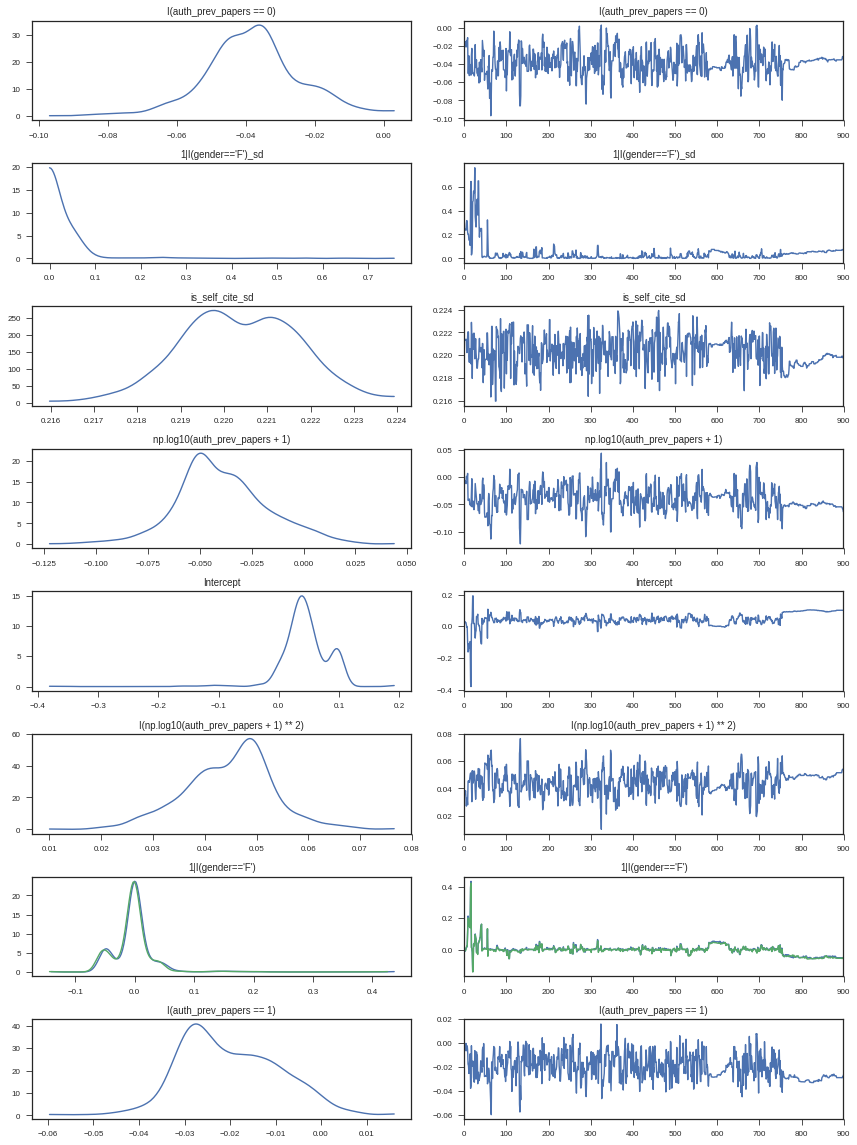

In [55]:
results[100:].plot()

In [56]:
results[100:].summary(ranefs=True)

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/bambi/results.py:346: UserWarning: Multiple MCMC chains are required in order to compute convergence diagnostics.
  warnings.warn('Multiple MCMC chains are required in order '


,mean,sd,hpd0.95_lower,hpd0.95_upper
1|I(gender == 'F')[False],-0.001151,0.037598,-0.056117,0.049701
1|I(gender == 'F')[True],-0.003557,0.037211,-0.060585,0.041850
1|I(gender=='F')_sd,0.038701,0.078857,0.000014,0.103080
I(auth_prev_papers == 0),-0.038119,0.014020,-0.064268,-0.007719
I(auth_prev_papers == 1),-0.020105,0.010725,-0.036769,0.001919
I(np.log10(auth_prev_papers + 1) ** 2),0.044541,0.008407,0.026558,0.059693
Intercept,0.043910,0.040540,-0.002829,0.103333
is_self_cite_sd,0.220345,0.001362,0.217944,0.223128
np.log10(auth_prev_papers + 1),-0.039475,0.022008,-0.077879,0.007790
